In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
from logger import get_logger
_logs = get_logger(__name__)

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

c:\Users\omovc\Programs\miniconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
C:\Users\omovc\AppData\Local\Temp\ipykernel_29724\1500862777.py:1: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedb

In [3]:
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index()

# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [4]:
df.sample(n = 5)

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,sector,subsector,year,Close_lag_1,returns,positive_return,target
930351,PCG,2009-04-06,36.810001,37.250000,36.500000,36.790001,26.455135,3323100,Utilities,Multi-Utilities,2009,37.180000,-0.010489,0,1.0
2578954,IT,2021-12-06,308.470001,310.529999,303.730011,307.420013,307.420013,319400,Information Technology,IT Consulting & Other Services,2021,309.399994,-0.006399,0,1.0
2634945,GPN,2009-02-13,17.695000,18.030001,17.590000,17.625000,16.857141,879600,Financials,Transaction & Payment Processing Services,2009,17.760000,-0.007601,0,0.0
1126598,CMI,2020-07-30,196.550003,196.970001,192.339996,194.479996,175.491241,769800,Industrials,Construction Machinery & Heavy Transportation ...,2020,198.880005,-0.022124,0,0.0
2249921,EL,2003-12-18,18.775000,19.125000,18.764999,18.950001,14.874719,1733800,Consumer Staples,Personal Care Products,2003,18.635000,0.016904,1,0.0


In [5]:
# select_tickers = df['ticker'].unique().tolist()[0:9]
select_tickers = ['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']
select_tickers

['OXY', 'TXN', 'PCG', 'CBRE', 'ROK', 'AMT', 'D', 'YUM', 'PWR']

In [6]:
idx = df['ticker'].isin(select_tickers)
small_df = df[idx]
simple_sample_dt = small_df.sample(frac = 0.1)
simple_sample_dt.shape, small_df.shape

((5441, 15), (54407, 15))

Look at the distribution of tickers.

<Axes: xlabel='ticker'>

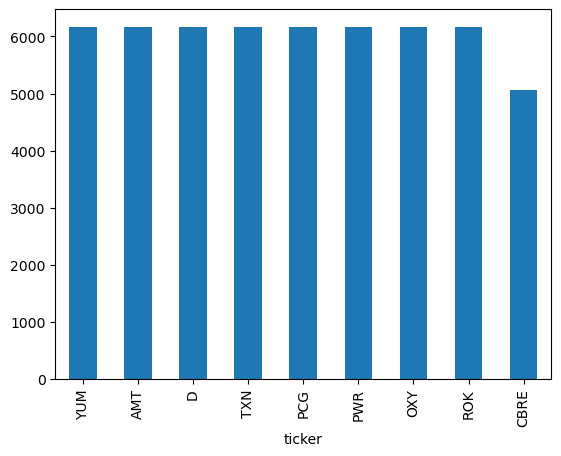

In [7]:
small_df['ticker'].value_counts().plot(kind='bar')

<Axes: xlabel='ticker'>

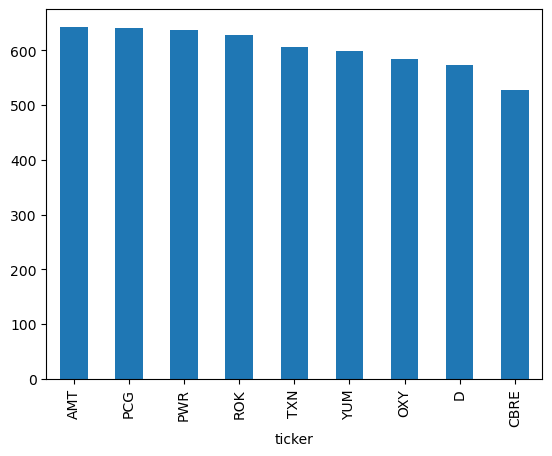

In [8]:
simple_sample_dt['ticker'].value_counts().plot(kind='bar')

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: xlabel='ticker'>

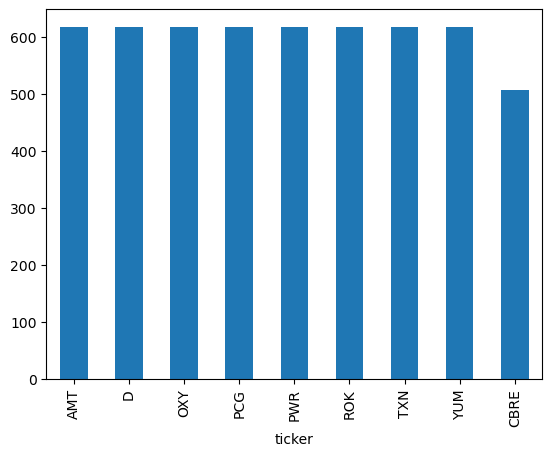

In [9]:
strat_sample_dt = small_df.groupby(['ticker']).sample(frac = 0.1)
strat_sample_dt['ticker'].value_counts().plot(kind='bar')

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

C:\Users\omovc\AppData\Local\Temp\ipykernel_29724\2932236319.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  strat_sample_dd_dt = (dd_dt


<Axes: xlabel='ticker'>

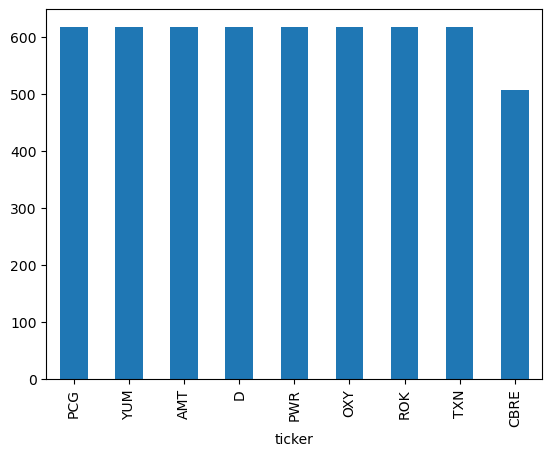

In [10]:
dd_dt = dd.read_parquet(ft_glob)
strat_sample_dd_dt = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1))
                      .compute()
                      .reset_index())
strat_sample_dd_dt[strat_sample_dd_dt['ticker'].isin(select_tickers)]['ticker'].value_counts().plot(kind='bar')